<a href="https://colab.research.google.com/github/iMan0405/Data_Science_Cert/blob/main/Aviachipta_narxini_bashorat_qilish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aviachipta narxini bashorat qilish
### Aviakompaniyalar uchun aviachiptalarning kelajakdagi narxlari qanday bo'lishini aniqlash

### Kerakli kutubxonalarni yuklab olamiz

In [127]:
import pandas as pd
import numpy as np
import sklearn
from fastai.vision.all import *
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import tensorflow as tf
import pickle

### Kaggle tomonidan berilgan data fayllarni yuklab ma'lumotini ko'ramiz

In [194]:
sample_solution = pd.read_csv('/content/sample_solution.csv', index_col=0)
test_data = pd.read_csv('/content/test_data.csv', index_col=0)
train_data = pd.read_csv('/content/train_data.csv', index_col=0)

In [195]:
sample_solution.head()

,price
id,
1,0
2,0
3,0
4,0
5,0


In [196]:
sample_solution.shape

(5000, 1)

In [197]:
test_data = test_data.drop('flight', axis=1)
test_data.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
id,,,,,,,,,
1,Air_India,Kolkata,Evening,one,Night,Delhi,Business,28.25,2
2,Vistara,Delhi,Early_Morning,one,Night,Mumbai,Business,13.83,34
3,Air_India,Mumbai,Early_Morning,zero,Early_Morning,Chennai,Business,2.00,30
4,AirAsia,Hyderabad,Night,one,Late_Night,Delhi,Economy,5.17,26
5,Air_India,Kolkata,Night,one,Afternoon,Mumbai,Economy,16.33,35


### Test data jadvali bo'yicha ma'lumotlarni ko'ramiz

In [198]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 5000
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline           5000 non-null   object 
 1   source_city       5000 non-null   object 
 2   departure_time    5000 non-null   object 
 3   stops             5000 non-null   object 
 4   arrival_time      5000 non-null   object 
 5   destination_city  5000 non-null   object 
 6   class             5000 non-null   object 
 7   duration          5000 non-null   float64
 8   days_left         5000 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 390.6+ KB


In [199]:
test_data.shape

(5000, 9)

In [200]:
train_data = train_data.drop('flight', axis=1)
train_data.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
id,,,,,,,,,,
1,Vistara,Bangalore,Early_Morning,one,Night,Mumbai,Economy,14.25,21,7212
2,SpiceJet,Hyderabad,Evening,zero,Night,Kolkata,Economy,1.75,7,5292
3,Vistara,Bangalore,Morning,one,Evening,Delhi,Business,9.58,5,60553
4,Vistara,Kolkata,Morning,one,Evening,Hyderabad,Economy,6.75,28,5760
5,Indigo,Chennai,Early_Morning,zero,Morning,Mumbai,Economy,2.00,4,10712


### Train data jadvali bo'yicha ma'lumotlarni ko'ramiz

In [201]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 1 to 20000
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline           20000 non-null  object 
 1   source_city       20000 non-null  object 
 2   departure_time    20000 non-null  object 
 3   stops             20000 non-null  object 
 4   arrival_time      20000 non-null  object 
 5   destination_city  20000 non-null  object 
 6   class             20000 non-null  object 
 7   duration          20000 non-null  float64
 8   days_left         20000 non-null  int64  
 9   price             20000 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 1.7+ MB


In [202]:
train_data.shape

(20000, 10)

### train data correlatsiyasini ko'ramiz

In [203]:
train_data.corrwith(train_data['price'])

<ipython-input-203-c5e969a065f8>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_data.corrwith(train_data['price'])


duration     0.213158
days_left   -0.102545
price        1.000000
dtype: float64

In [204]:
col = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']

X_train = train_data.drop('price', axis=1)
y = train_data['price'].copy()

X_num = X_train.drop(col, axis=1)

### X_Train, y va X_num larni ko'ramiz

In [205]:
X_train.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
id,,,,,,,,,
1,Vistara,Bangalore,Early_Morning,one,Night,Mumbai,Economy,14.25,21
2,SpiceJet,Hyderabad,Evening,zero,Night,Kolkata,Economy,1.75,7
3,Vistara,Bangalore,Morning,one,Evening,Delhi,Business,9.58,5
4,Vistara,Kolkata,Morning,one,Evening,Hyderabad,Economy,6.75,28
5,Indigo,Chennai,Early_Morning,zero,Morning,Mumbai,Economy,2.00,4


In [206]:
y.head()

id
1     7212
2     5292
3    60553
4     5760
5    10712
Name: price, dtype: int64

In [207]:
X_num.head()

,duration,days_left
id,,
1,14.25,21
2,1.75,7
3,9.58,5
4,6.75,28
5,2.00,4


### Pipeline quramiz

### Sonli ustun uchun konveyr yaratamiz

In [208]:
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

### Pipeline ni ishga tushuramiz

In [209]:
num_pipeline.fit_transform(X_num)

array([[ 0.28952803, -0.36141789],
       [-1.45682723, -1.38897606],
       [-0.36291029, -1.53577008],
       ...,
       [ 3.23458153, -0.65500594],
       [ 0.58012154, -0.36141789],
       [ 0.84836171,  0.00556716]])

### Matnli ustunlarga ishlov berish

In [210]:
num_attribs = list(X_num)
cat_attribs = col

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

### Konveyrni ishga tushiramiz

In [211]:
X_prepared = full_pipeline.fit_transform(X_train)

In [212]:
X_prepared[:, :]

<20000x37 sparse matrix of type '<class 'numpy.float64'>'
	with 180000 stored elements in Compressed Sparse Row format>

# Machine Learning

In [213]:
LR_Model = LinearRegression()

In [214]:
LR_Model.fit(X_prepared, y)

LinearRegression()

In [215]:
test = X_train.sample(10)
test

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
id,,,,,,,,,
4403,AirAsia,Hyderabad,Evening,one,Night,Bangalore,Economy,7.67,43
9714,Vistara,Hyderabad,Morning,two_or_more,Night,Chennai,Economy,11.75,18
6157,AirAsia,Kolkata,Evening,one,Night,Bangalore,Economy,4.17,42
19473,Air_India,Kolkata,Evening,one,Morning,Chennai,Business,18.00,46
13558,Indigo,Chennai,Evening,zero,Night,Mumbai,Economy,2.00,13
11283,Air_India,Delhi,Early_Morning,one,Afternoon,Mumbai,Economy,8.83,14
17078,Indigo,Mumbai,Evening,one,Night,Bangalore,Economy,3.75,14
3454,Vistara,Mumbai,Early_Morning,one,Evening,Hyderabad,Economy,9.50,35
10772,Air_India,Mumbai,Evening,one,Evening,Bangalore,Economy,24.75,34


In [216]:
test_label = y.loc[test.index]
test_label

id
4403      2738
9714      9318
6157      4648
19473    55087
13558     6304
11283    11900
17078     5103
3454      5099
10772     3951
13330    44405
Name: price, dtype: int64

In [217]:
test_prepared = full_pipeline.transform(test)
test_prepared

<10x37 sparse matrix of type '<class 'numpy.float64'>'
	with 90 stored elements in Compressed Sparse Row format>

In [218]:
predicted_data = LR_Model.predict(test_prepared)
predicted_data

array([ 2321.21542681, 11875.82777762,  5625.24762633, 49680.41554095,
        2033.12361477,  5745.24967051,  9878.6351617 ,  7664.35554771,
        6017.98904723, 47366.55639067])

In [219]:
pd.DataFrame({'Taxminiy baxosi':predicted_data, 'Haqiqiy baxosi': test_label})

,Taxminiy baxosi,Haqiqiy baxosi
id,,
4403,2321.215427,2738
9714,11875.827778,9318
6157,5625.247626,4648
19473,49680.415541,55087
13558,2033.123615,6304
11283,5745.249671,11900
17078,9878.635162,5103
3454,7664.355548,5099
10772,6017.989047,3951


### Xatolikni tekshiramiz

In [220]:
mse = mean_squared_error(test_label, predicted_data)
rmse = np.sqrt(mse)
print(rmse)

3680.417065130779


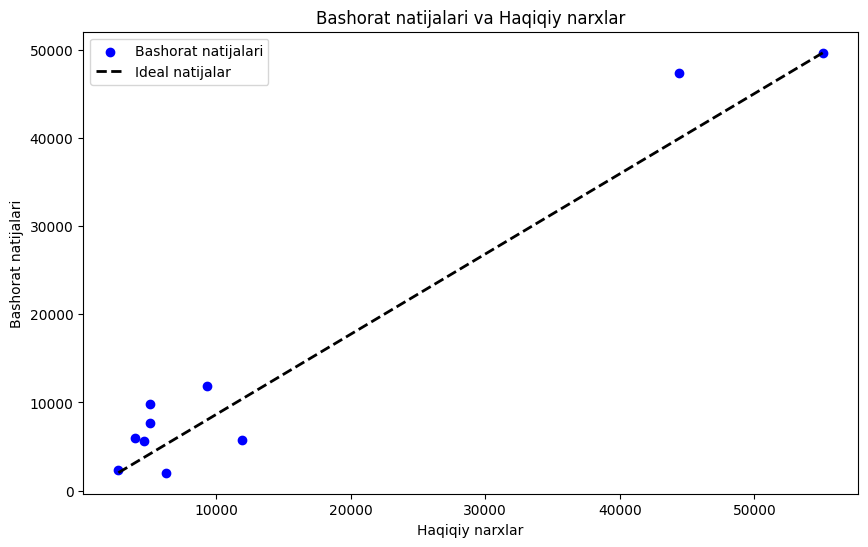

In [221]:
# Bashorat natijalarni grafikda chizish
plt.figure(figsize=(10, 6))
plt.scatter(test_label, predicted_data, color='blue', label='Bashorat natijalari')
plt.plot([min(test_label), max(test_label)], [min(predicted_data), max(predicted_data)], 'k--', lw=2, label='Ideal natijalar')
plt.xlabel('Haqiqiy narxlar')
plt.ylabel('Bashorat natijalari')
plt.title('Bashorat natijalari va Haqiqiy narxlar')
plt.legend()
plt.show()

# Modelni baholash

### test data da sinov

In [222]:
test_data

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
id,,,,,,,,,
1,Air_India,Kolkata,Evening,one,Night,Delhi,Business,28.25,2
2,Vistara,Delhi,Early_Morning,one,Night,Mumbai,Business,13.83,34
3,Air_India,Mumbai,Early_Morning,zero,Early_Morning,Chennai,Business,2.00,30
4,AirAsia,Hyderabad,Night,one,Late_Night,Delhi,Economy,5.17,26
5,Air_India,Kolkata,Night,one,Afternoon,Mumbai,Economy,16.33,35
...,...,...,...,...,...,...,...,...,...
4996,Air_India,Kolkata,Afternoon,one,Morning,Bangalore,Business,17.42,15
4997,Indigo,Kolkata,Morning,zero,Afternoon,Mumbai,Economy,3.00,40
4998,Air_India,Kolkata,Morning,one,Night,Mumbai,Business,11.17,37


### testni pipeline dan o'tkazish

In [223]:
test_data_prepared = full_pipeline.transform(test_data)

In [224]:
y_predicted = LR_Model.predict(test_data_prepared)
y_predicted

array([55954.37763147, 53515.85361649, 40638.68279412, ...,
       51475.43234705, 48599.737154  , 51809.17049893])

In [225]:
pd.DataFrame({'Test data jadvalidagi chiptalar narxini taxminiy baxosi':y_predicted})

,Test data jadvalidagi chiptalar narxini taxminiy baxosi
0,55954.377631
1,53515.853616
2,40638.682794
3,2403.004663
4,5894.522567
...,...
4995,53356.323245
4996,-884.865969
4997,51475.432347
4998,48599.737154


# DecisionTree modeli

In [226]:
Tree_model = DecisionTreeRegressor()
Tree_model.fit(X_prepared, y)

DecisionTreeRegressor()

In [227]:
test = X_train.sample(10)
test

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
id,,,,,,,,,
2885,Air_India,Hyderabad,Early_Morning,one,Evening,Delhi,Economy,12.00,47
13635,Vistara,Delhi,Night,one,Morning,Chennai,Business,15.17,10
14387,SpiceJet,Delhi,Evening,zero,Night,Bangalore,Economy,2.75,1
10905,Vistara,Chennai,Morning,one,Evening,Mumbai,Business,8.33,19
3695,Air_India,Mumbai,Morning,two_or_more,Morning,Chennai,Economy,22.92,15
15018,AirAsia,Bangalore,Afternoon,one,Night,Kolkata,Economy,7.50,21
1507,Air_India,Mumbai,Night,one,Night,Hyderabad,Economy,24.33,12
4013,Air_India,Chennai,Morning,one,Evening,Bangalore,Economy,29.75,14
13831,Vistara,Bangalore,Morning,one,Evening,Delhi,Economy,5.00,24


In [228]:
test_label = y.loc[test.index]
test_label

id
2885      4172
13635    53624
14387    18660
10905    57393
3695      9576
15018     3393
1507     14658
4013     13863
13831    12267
19528    57778
Name: price, dtype: int64

In [229]:
test_prepared = full_pipeline.transform(test)
test_prepared

<10x37 sparse matrix of type '<class 'numpy.float64'>'
	with 90 stored elements in Compressed Sparse Row format>

In [230]:
predicted_data = Tree_model.predict(test_prepared)
predicted_data

array([ 4172., 53624., 18660., 57393.,  9576.,  3393., 14658., 13863.,
       12267., 57778.])

In [231]:
pd.DataFrame({'Taxminiy baxosi':predicted_data, 'Haqiqiy baxosi': test_label})

,Taxminiy baxosi,Haqiqiy baxosi
id,,
2885,4172.0,4172
13635,53624.0,53624
14387,18660.0,18660
10905,57393.0,57393
3695,9576.0,9576
15018,3393.0,3393
1507,14658.0,14658
4013,13863.0,13863
13831,12267.0,12267


In [232]:
mse = mean_squared_error(test_label, predicted_data)
rmse = np.sqrt(mse)
print(rmse)

0.0


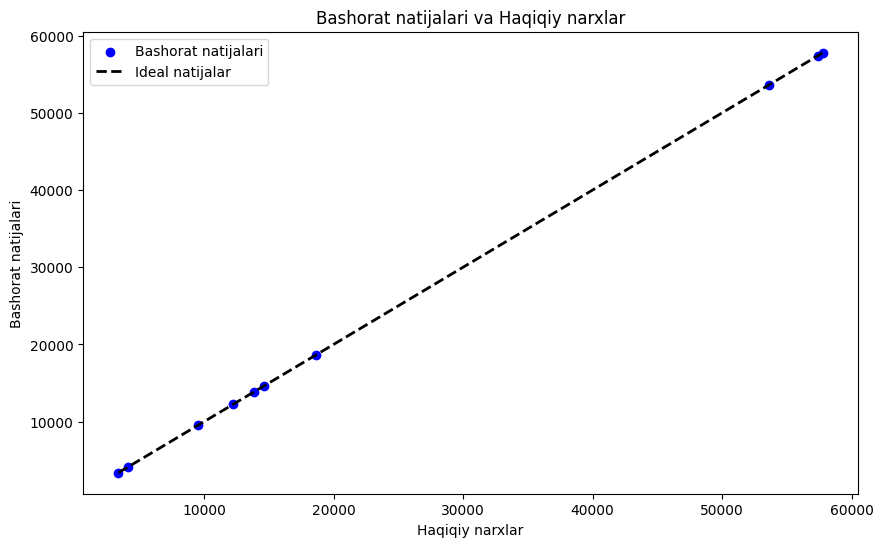

In [233]:
# Bashorat natijalarni grafikda chizish
plt.figure(figsize=(10, 6))
plt.scatter(test_label, predicted_data, color='blue', label='Bashorat natijalari')
plt.plot([min(test_label), max(test_label)], [min(predicted_data), max(predicted_data)], 'k--', lw=2, label='Ideal natijalar')
plt.xlabel('Haqiqiy narxlar')
plt.ylabel('Bashorat natijalari')
plt.title('Bashorat natijalari va Haqiqiy narxlar')
plt.legend()
plt.show()

# Modelni baholash

### test data da sinov

In [234]:
test_data_prepared = full_pipeline.transform(test_data)
y_predicted = Tree_model.predict(test_data_prepared)
pd.DataFrame({'Test data jadvalidagi chiptalar narxini taxminiy baxosi':y_predicted})

,Test data jadvalidagi chiptalar narxini taxminiy baxosi
0,54863.0
1,51384.0
2,23484.0
3,2228.0
4,5102.0
...,...
4995,60978.0
4996,3862.0
4997,50271.0
4998,50868.0


### sample_solution ga test data bo'yicha predict chipta bahosini saqlaymiz

In [235]:
sample_solution['price'] = y_predicted
sample_solution

,price
id,
1,54863.0
2,51384.0
3,23484.0
4,2228.0
5,5102.0
...,...
4996,60978.0
4997,3862.0
4998,50271.0


# RandomForest modeli

In [236]:
RF_model = RandomForestRegressor()
RF_model.fit(X_prepared, y)

RandomForestRegressor()

In [237]:
test = X_train.sample(10)
test

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
id,,,,,,,,,
14150,Air_India,Chennai,Night,one,Morning,Mumbai,Business,12.75,43
2530,Air_India,Bangalore,Early_Morning,one,Evening,Mumbai,Economy,11.83,44
18265,Vistara,Mumbai,Evening,zero,Evening,Delhi,Economy,2.17,41
53,Air_India,Chennai,Night,one,Evening,Bangalore,Economy,19.92,26
3245,Air_India,Mumbai,Evening,one,Morning,Chennai,Business,13.92,12
1902,Indigo,Delhi,Early_Morning,one,Morning,Kolkata,Economy,6.08,7
11890,Vistara,Kolkata,Evening,one,Morning,Delhi,Business,17.42,16
16918,Vistara,Mumbai,Afternoon,one,Night,Chennai,Economy,8.08,6
2683,Vistara,Mumbai,Evening,one,Morning,Hyderabad,Business,15.17,24


In [238]:
test_label = y.loc[test.index]
test_label

id
14150    49553
2530      6578
18265     3024
53        5888
3245     49613
1902      5955
11890    68303
16918    11129
2683     60365
15942    12138
Name: price, dtype: int64

In [239]:
test_prepared = full_pipeline.transform(test)
predicted_data = RF_model.predict(test_prepared)
pd.DataFrame({'Taxminiy baxosi':predicted_data, 'Haqiqiy baxosi': test_label})

,Taxminiy baxosi,Haqiqiy baxosi
id,,
14150,49230.44,49553
2530,6519.29,6578
18265,2825.79,3024
53,5851.22,5888
3245,49539.80,49613
1902,7754.53,5955
11890,68503.15,68303
16918,11531.17,11129
2683,60583.20,60365


In [240]:
mse = mean_squared_error(test_label, predicted_data)
rmse = np.sqrt(mse)
print(rmse)

649.6185094807562


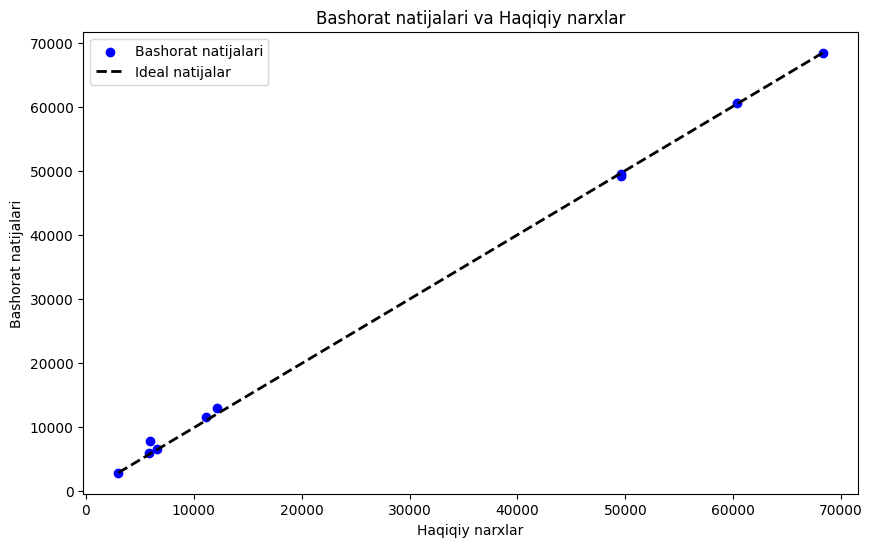

In [241]:
# Bashorat natijalarni grafikda chizish
plt.figure(figsize=(10, 6))
plt.scatter(test_label, predicted_data, color='blue', label='Bashorat natijalari')
plt.plot([min(test_label), max(test_label)], [min(predicted_data), max(predicted_data)], 'k--', lw=2, label='Ideal natijalar')
plt.xlabel('Haqiqiy narxlar')
plt.ylabel('Bashorat natijalari')
plt.title('Bashorat natijalari va Haqiqiy narxlar')
plt.legend()
plt.show()

In [242]:
test_data_prepared = full_pipeline.transform(test_data)
y_predicted = RF_model.predict(test_data_prepared)
pd.DataFrame({'Test data jadvalidagi chiptalar narxini taxminiy baxosi':y_predicted})

,Test data jadvalidagi chiptalar narxini taxminiy baxosi
0,52498.26
1,55733.53
2,23443.32
3,2516.56
4,5708.27
...,...
4995,59911.15
4996,4520.98
4997,50272.36
4998,48953.25


### Funksiya yordamida validation ma'lumotlarini ko'rsatamiz

In [243]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Std.dev:", scores.std())

In [244]:
scores = cross_val_score(LR_Model, X_prepared, y, scoring="neg_mean_squared_error", cv=10)
LR_rmse_scores = np.sqrt(-scores)
display_scores(LR_rmse_scores)

Scores: [6753.83385444 6729.41242916 6676.00757311 6361.75662097 6727.57519518
 6736.04629409 6923.49287861 6539.54368144 6716.57906969 6994.14812375]
Mean: 6715.839572045622
Std.dev: 167.56833900552056


# Decision Tree modeli

In [245]:
scores = cross_val_score(Tree_model, X_prepared, y, scoring="neg_mean_squared_error", cv=10)
LR_rmse_scores = np.sqrt(-scores)
display_scores(LR_rmse_scores)

Scores: [4724.83227455 4596.29089661 5317.64689715 4724.27727908 4792.78419679
 4855.92991611 5082.08997429 5101.80362743 4782.41776397 5248.09590514]
Mean: 4922.6168731104335
Std.dev: 233.54449946628884


# Random Forest modeli

In [246]:
scores = cross_val_score(RF_model, X_prepared, y, scoring="neg_mean_squared_error", cv=10)
LR_rmse_scores = np.sqrt(-scores)
display_scores(LR_rmse_scores)

Scores: [3562.62299548 3873.36728518 4034.31434579 3451.8520717  3607.28204588
 3743.24105136 4021.02529788 3724.82993192 3718.80165754 3826.68351782]
Mean: 3756.402020056229
Std.dev: 179.16546691417406


# Modelni Saqlash

### LinearRegression model

In [188]:
filename = 'LR_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(LR_Model, file)

### Decision model

In [189]:
filename = 'Tree_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(Tree_model, file)

### Random forest model

In [187]:
filename = 'RF_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(RF_model, file)

### Modelni qayta o'qish (test uchun)

In [192]:
filename = 'Tree_model.pkl'
with open(filename, 'rb') as file:
    model = pickle.load(file)

### Modelni sinab ko'rish

In [193]:
scores = cross_val_score(model, X_prepared, y, scoring="neg_mean_squared_error", cv=5)
LR_rmse_scores = np.sqrt(-scores)
display_scores(LR_rmse_scores)

Scores: [4962.65428814 5091.07974547 4799.05877537 5133.58290277 5026.56466741]
Mean: 5002.588075833432
Std.dev: 117.11889751085074
